# converting raw data into data needed for website

In [132]:
import pandas as pd

In [133]:
raw_data = pd.read_csv('C:/Users/HP/Downloads/selected_variables.csv')

C:\Users\HP\AppData\Local\Temp\ipykernel_5696\4149667289.py:1: DtypeWarning: Columns (211,212,213,214,215,217,218,219,220,221,286) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('C:/Users/HP/Downloads/selected_variables.csv')


In [134]:
import re

# filter out vars with many missings (from milestone 1)
pattern_region = re.compile(r'^regio.*', flags=re.IGNORECASE)
region_columns = list(filter(pattern_region.match, raw_data.columns))
region_df = raw_data[region_columns]

pattern_parties = re.compile(r'^prtv.*', flags=re.IGNORECASE)
party_votes_columns = list(filter(pattern_parties.match, raw_data.columns))
parties_df = raw_data[party_votes_columns]

other_variables_col = list(filter(lambda col: not(pattern_parties.match(col) or pattern_region.match(col)), raw_data.columns))
raw_data_subset = raw_data[other_variables_col]

raw_data_subset.head()

,name,essround,edition,proddate,idno,cntry,dweight,pspwght,pweight,anweight,...,iplylfr,iprspot,ipshabt,ipstrgv,ipsuces,ipudrst,regunit,ccrdprs,ccnthum,wrclmch
0,ESS1e06_7,1,6.7,23.11.2023,1,AT,0.9452,0.940933,0.271487,0.255451,...,2.0,4.0,3.0,2.0,3.0,3.0,NaN,NaN,NaN,NaN
1,ESS1e06_7,1,6.7,23.11.2023,2,AT,0.4726,0.470466,0.271487,0.127726,...,3.0,4.0,2.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN
2,ESS1e06_7,1,6.7,23.11.2023,3,AT,0.9452,1.392155,0.271487,0.377953,...,2.0,3.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN
3,ESS1e06_7,1,6.7,23.11.2023,4,AT,0.9452,1.382163,0.271487,0.375240,...,2.0,4.0,4.0,3.0,4.0,1.0,NaN,NaN,NaN,NaN
4,ESS1e06_7,1,6.7,23.11.2023,6,AT,1.8905,1.437766,0.271487,0.390336,...,1.0,5.0,3.0,4.0,4.0,1.0,NaN,NaN,NaN,NaN


In [135]:
# assign year of response variable
raw_data_subset.loc[:,'essround_yr'] = raw_data_subset['essround']*2+2000

C:\Users\HP\AppData\Local\Temp\ipykernel_5696\2770427449.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_subset.loc[:,'essround_yr'] = raw_data_subset['essround']*2+2000


C:\Users\HP\AppData\Local\Temp\ipykernel_5696\4100544405.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_subset.loc[:,'age_group'] = pd.cut(raw_data['agea'], bins=bins, labels=labels, right=False)


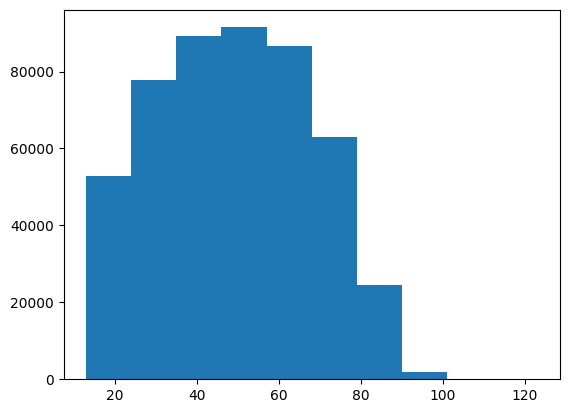

In [136]:
# see age distribution
import matplotlib.pyplot as plt
age_data = raw_data_subset[raw_data_subset['agea'] != 999]
plt.hist(age_data['agea'], bins=10)

# assign age group variable
bins = [0, 25, 39, 59, float('inf')]
labels = ['<25', '25-39', '40-59', '60+']
raw_data_subset.loc[:,'age_group'] = pd.cut(raw_data['agea'], bins=bins, labels=labels, right=False)
raw_data_subset.loc[:,'age_group'] = raw_data_subset['age_group'].astype('category')

In [231]:
# Helper function: prepare_for_aggregation()
### removes missing values, ensures increase implies improvement, and 0-1 normalizes ninned variables
def prepare_for_aggregation(data, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges):

    # ignore missings, organize vars s.t. higher = better, normalize
    for var, cutoff, order, range in zip(vars, vars_missing_cutoffs, vars_improve_order, vars_ranges):
        data[var] = data[var].where(data[var] <= cutoff, other=float('nan'))
        if order == -1:
            data[var] *= -1
            range = sorted([val*-1 for val in range])
        data[var] = (data[var] - range[0]) / (range[1] - range[0])
    return data

# Fig 1: Bar Chart

In [232]:
def bar_age_yr(data, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges):
    # subset data to obs not missing agea
    temp = data[data['agea'] != 999][vars + ['essround_yr', 'age_group']]

    # prepare binned variables for aggregation
    prepare_for_aggregation(temp, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges)

    # average in-group constituent var averages, create index by age group where <25, 2002 is 100
    temp = temp.groupby(['essround_yr', 'age_group'])[vars].mean().reset_index()
    temp['average'] = temp[vars].mean(axis=1)
    temp = temp.sort_values(by=['age_group', 'essround_yr'])
    temp['average_index'] = (temp['average'] / temp.loc[(temp['essround_yr'] == 2002) & (temp['age_group'] == '<25'), 'average'].values[0]) * 100
    return temp[['essround_yr', 'age_group', 'average_index']]

In [233]:
# 'quality of life / mental stress'
vars = ['happy', 'health'] # set of vars in aggregate index
vars_missing_cutoffs = [10, 5] # value above which variable should be considered missing for our purposes
vars_improve_order = [1, -1] # 1 if higher is better, -1 if lower is better
vars_ranges = [[1, 10], [1, 5]] # range variable can take - access via codebook (https://github.com/com-480-data-visualization/ChartToppers/blob/master/all_variables_codebook.html)

mental_stress_bar = bar_age_yr(raw_data_subset, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges)
mental_stress_bar.head(15)

C:\Users\HP\AppData\Local\Temp\ipykernel_5696\2222352289.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(['essround_yr', 'age_group'])[vars].mean().reset_index()


,essround_yr,age_group,average_index
0,2002,<25,100.000000
4,2004,<25,99.015825
8,2006,<25,99.171617
12,2008,<25,99.337559
16,2010,<25,101.181947
20,2012,<25,101.232809
24,2014,<25,102.327232
28,2016,<25,102.223807
32,2018,<25,103.318576
36,2020,<25,97.420800


# Fig 2: Choropleth

In [234]:
def choropleth_gend_cntry_age_yr(data, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges):

    # subset data to obs not missing agea or gender
    temp = data[(data['agea'] != 999) & (data['gndr'] != 9)][vars + ['cntry', 'gndr', 'essround_yr', 'age_group']]

    # prepare binned variables for aggregation
    prepare_for_aggregation(temp, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges)

    # average in-group constituent var averages, take differences
    temp = temp.groupby(['essround_yr', 'age_group', 'gndr', 'cntry'])[vars].mean().reset_index()
    temp['average'] = temp[vars].mean(axis=1)
    temp = temp.pivot_table(index=['cntry', 'age_group', 'essround_yr'],
                    columns='gndr',
                    values= vars + ['average'],
                    aggfunc='mean')
    temp.columns = [f"{col[0]}_{col[1]}" for col in temp.columns]
    temp = temp.reset_index()
    temp['m_minus_w_non_index'] = temp['average_1'] - temp['average_2']

    # create index for hover-over-country history. for each country, value for <25 in earliest year is 100 (for both women and men!)
    temp = temp.sort_values(by=['cntry', 'age_group', 'essround_yr'])
    temp['average_men_index'] = (temp['average_1'] / temp.groupby(['cntry'])['average_1'].transform('first')) * 100
    temp['average_women_index'] = (temp['average_2'] / temp.groupby(['cntry'])['average_1'].transform('first')) * 100
    temp['m_minus_w_country_level_index'] = temp['average_men_index'] - temp['average_women_index']
    return temp[['cntry', 'essround_yr', 'age_group', 'm_minus_w_non_index', 'average_men_index', 'average_women_index', 'm_minus_w_country_level_index']]    

In [235]:
mental_stress_choropleth = choropleth_gend_cntry_age_yr(raw_data_subset, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges)
mental_stress_choropleth.head(15)

C:\Users\HP\AppData\Local\Temp\ipykernel_5696\3040442615.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(['essround_yr', 'age_group', 'gndr', 'cntry'])[vars].mean().reset_index()
C:\Users\HP\AppData\Local\Temp\ipykernel_5696\3040442615.py:12: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  temp = temp.pivot_table(index=['cntry', 'age_group', 'essround_yr'],


,cntry,essround_yr,age_group,m_minus_w_non_index,average_men_index,average_women_index,m_minus_w_country_level_index
0,AL,2012,<25,0.030336,100.000000,95.952108,4.047892
1,AL,2012,25-39,0.019209,94.840300,92.277077,2.563223
2,AL,2012,40-59,0.014715,80.377100,78.413533,1.963568
3,AL,2012,60+,0.025855,77.861454,74.411447,3.450008
4,AT,2002,<25,0.003223,100.000000,99.585899,0.414101
5,AT,2004,<25,0.025675,101.907630,98.609263,3.298367
6,AT,2006,<25,0.020847,103.497580,100.819407,2.678173
7,AT,2014,<25,0.032921,108.814738,104.585439,4.229299
8,AT,2016,<25,-0.039218,103.370043,108.408247,-5.038204
9,AT,2018,<25,-0.005704,106.304619,107.037375,-0.732756


# Fig 3: Ordinal Country List

In [250]:
def ordinal_gend_cntry_yr(data, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges):

    # subset data to obs not missing agea or gender
    temp = data[(data['gndr'] != 9)][vars + ['cntry', 'gndr', 'essround_yr']]

    # double dataset, give duplicate instance contry code "All" (to populate average lines by year)
    temp_all = temp.copy()
    temp_all['cntry'] = "AGGREGATE"
    temp = pd.concat([temp, temp_all])

    # prepare binned variables for aggregation
    prepare_for_aggregation(temp, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges)

    # average in-group constituent var averages, take differences
    temp = temp.groupby(['essround_yr', 'gndr', 'cntry'])[vars].mean().reset_index()
    temp['average'] = temp[vars].mean(axis=1)
    temp = temp.pivot_table(index=['cntry', 'essround_yr'],
                    columns='gndr',
                    values= vars + ['average'],
                    aggfunc='mean')
    temp.columns = [f"{col[0]}_{col[1]}" for col in temp.columns]
    temp = temp.reset_index()

    # create index for hover-over-country history. for each country, value for <25 in earliest year is 100 (for both women and men!)
    temp = temp.sort_values(by=['cntry', 'essround_yr'])
    temp['average_men'] = temp['average_1']
    temp['average_women'] = temp['average_2']
    return temp[['cntry', 'essround_yr', 'average_men', 'average_women']]    

In [251]:
ordinal_gend_cntry_yr(raw_data_subset, vars, vars_missing_cutoffs, vars_improve_order, vars_ranges)

# data for pop-up text would be in choropleth function output

,cntry,essround_yr,average_men,average_women
0,AGGREGATE,2002,0.716922,0.697614
1,AGGREGATE,2004,0.700321,0.680260
2,AGGREGATE,2006,0.695017,0.668704
3,AGGREGATE,2008,0.683993,0.659480
4,AGGREGATE,2010,0.685597,0.663136
...,...,...,...,...
264,UA,2006,0.543206,0.493583
265,UA,2008,0.535666,0.473217
266,UA,2010,0.538324,0.490796
267,UA,2012,0.566641,0.548068
